# Alcohol levels in wine
### A notebook exploring regression analysis and alcohol

For this notebook, we're going to use the red wine dataset, found on [Kaggle](https://www.kaggle.com/piyushgoyal443/red-wine-dataset/version/1). You can also find this dataset in the [/data folder](https://github.com/DecodedCo/data-fellowship/tree/master/data) of the course repository.

Our aim is to practice regression analysis by predicting some numerical value for wines based on their other characteristics.

### Sourcing the data

In [1]:
# Import relevant packages

import numpy as np #

import pandas as pd # For dataframe manipulation

import matplotlib.pyplot as plt # For visualisations and plotting

from sklearn import linear_model, preprocessing # For linear regression modelling

from sklearn.metrics import mean_squared_error, r2_score # For evaluating models

from sklearn.model_selection import train_test_split # For splitting the data for testing purposes

import seaborn as sns # For visualisations

import statsmodels.api as sm # For linear regression modelling

from statsmodels.graphics.api import abline_plot # For visualling evaluating predictions

import warnings # For handling error messages

In [2]:
# Supress warnings about problems that don't yet exist

warnings.simplefilter(action="ignore", category=FutureWarning)

# Supress a warning in sklearn for a solved problem that only exists on Macs

warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [3]:
# Load the data

data = pd.read_csv("wineQualityReds.csv", index_col=0)

# The index_col parameter allows us to ignore the first column which contains no useful data.

### Exploring the data

In [4]:
# Examine the dimensions of the dataset - let's see how much data we're working with:

print("Rows:", data.shape[0])
print("Columns:", data.shape[1])

Rows: 1599
Columns: 12


In [5]:
# Inspect the data, just to check it is all okay

data.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
1,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
2,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
3,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
4,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
5,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


The data has been loaded successfully, and we've learnt a bit about it. Now we need to find a variable to predict using regression. Let's start by looking at quality.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11177bd30>]],
      dtype=object)

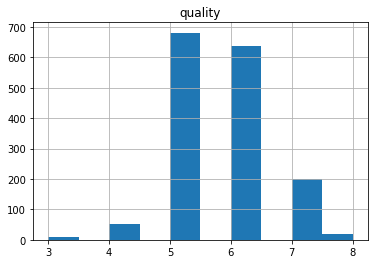

In [6]:
# Create a histogram of the quality variable:

data.hist(column="quality")

Two things are immediately clear from this histogram:

1. The vast majority of wines are rated at a 5 or a 6 for quality.

2. No wine is rated as below 3 in quality, or above 8

Quality does not appear to be a continuous variable - every value is an integer. This means it's not a great target for regressional analysis. Before we dismiss it and choose another variable, let's check that our understanding is correct.

In [7]:
# Get the accurate counts for each number in quality

data["quality"].value_counts(dropna=False)

# The dropna parameter ensures that we also see any missing values in this list

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [8]:
# Gather basic statistical information about the quality variable

data["quality"].describe()

count    1599.000000
mean        5.636023
std         0.807569
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         8.000000
Name: quality, dtype: float64

We can see that the minimum value is 3 and the max is 8, which matches our histogram. There are as many values as there are rows in the dataset, so we know that there are no NAs. The mean is 5.6, which matches our previous observation that the majority of values were either five or six.

Everything we've seen so far shows that quality is a discrete variable, not a continuous one.

In [9]:
# Examine the data types of our dataset

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1599 entries, 1 to 1599
Data columns (total 12 columns):
fixed.acidity           1599 non-null float64
volatile.acidity        1599 non-null float64
citric.acid             1599 non-null float64
residual.sugar          1599 non-null float64
chlorides               1599 non-null float64
free.sulfur.dioxide     1599 non-null float64
total.sulfur.dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 162.4 KB


We can see that all our variables are numeric, and that all except quality are continuous. 

We can also see that the dataset contains no null values at all, which will make cleaning easier.

As quality is not a continuous variable, the correct method to predict it would be classification, not regression - the data is numeric, but it falls into distinct *categories*.

This notebook is focused on regression, not classification. Because of this, we're not going to focus on quality any more. Instead, we will pick a different, continuous variable.

Any one of the other variables would work, as they are all continuous. If we can't use regression to predict the quality of wine, predicting the level of alcohol seems like the next priority. 

Let's examine the data to see if we can find any interesting relationships that might suggest how best to approach making that prediction.

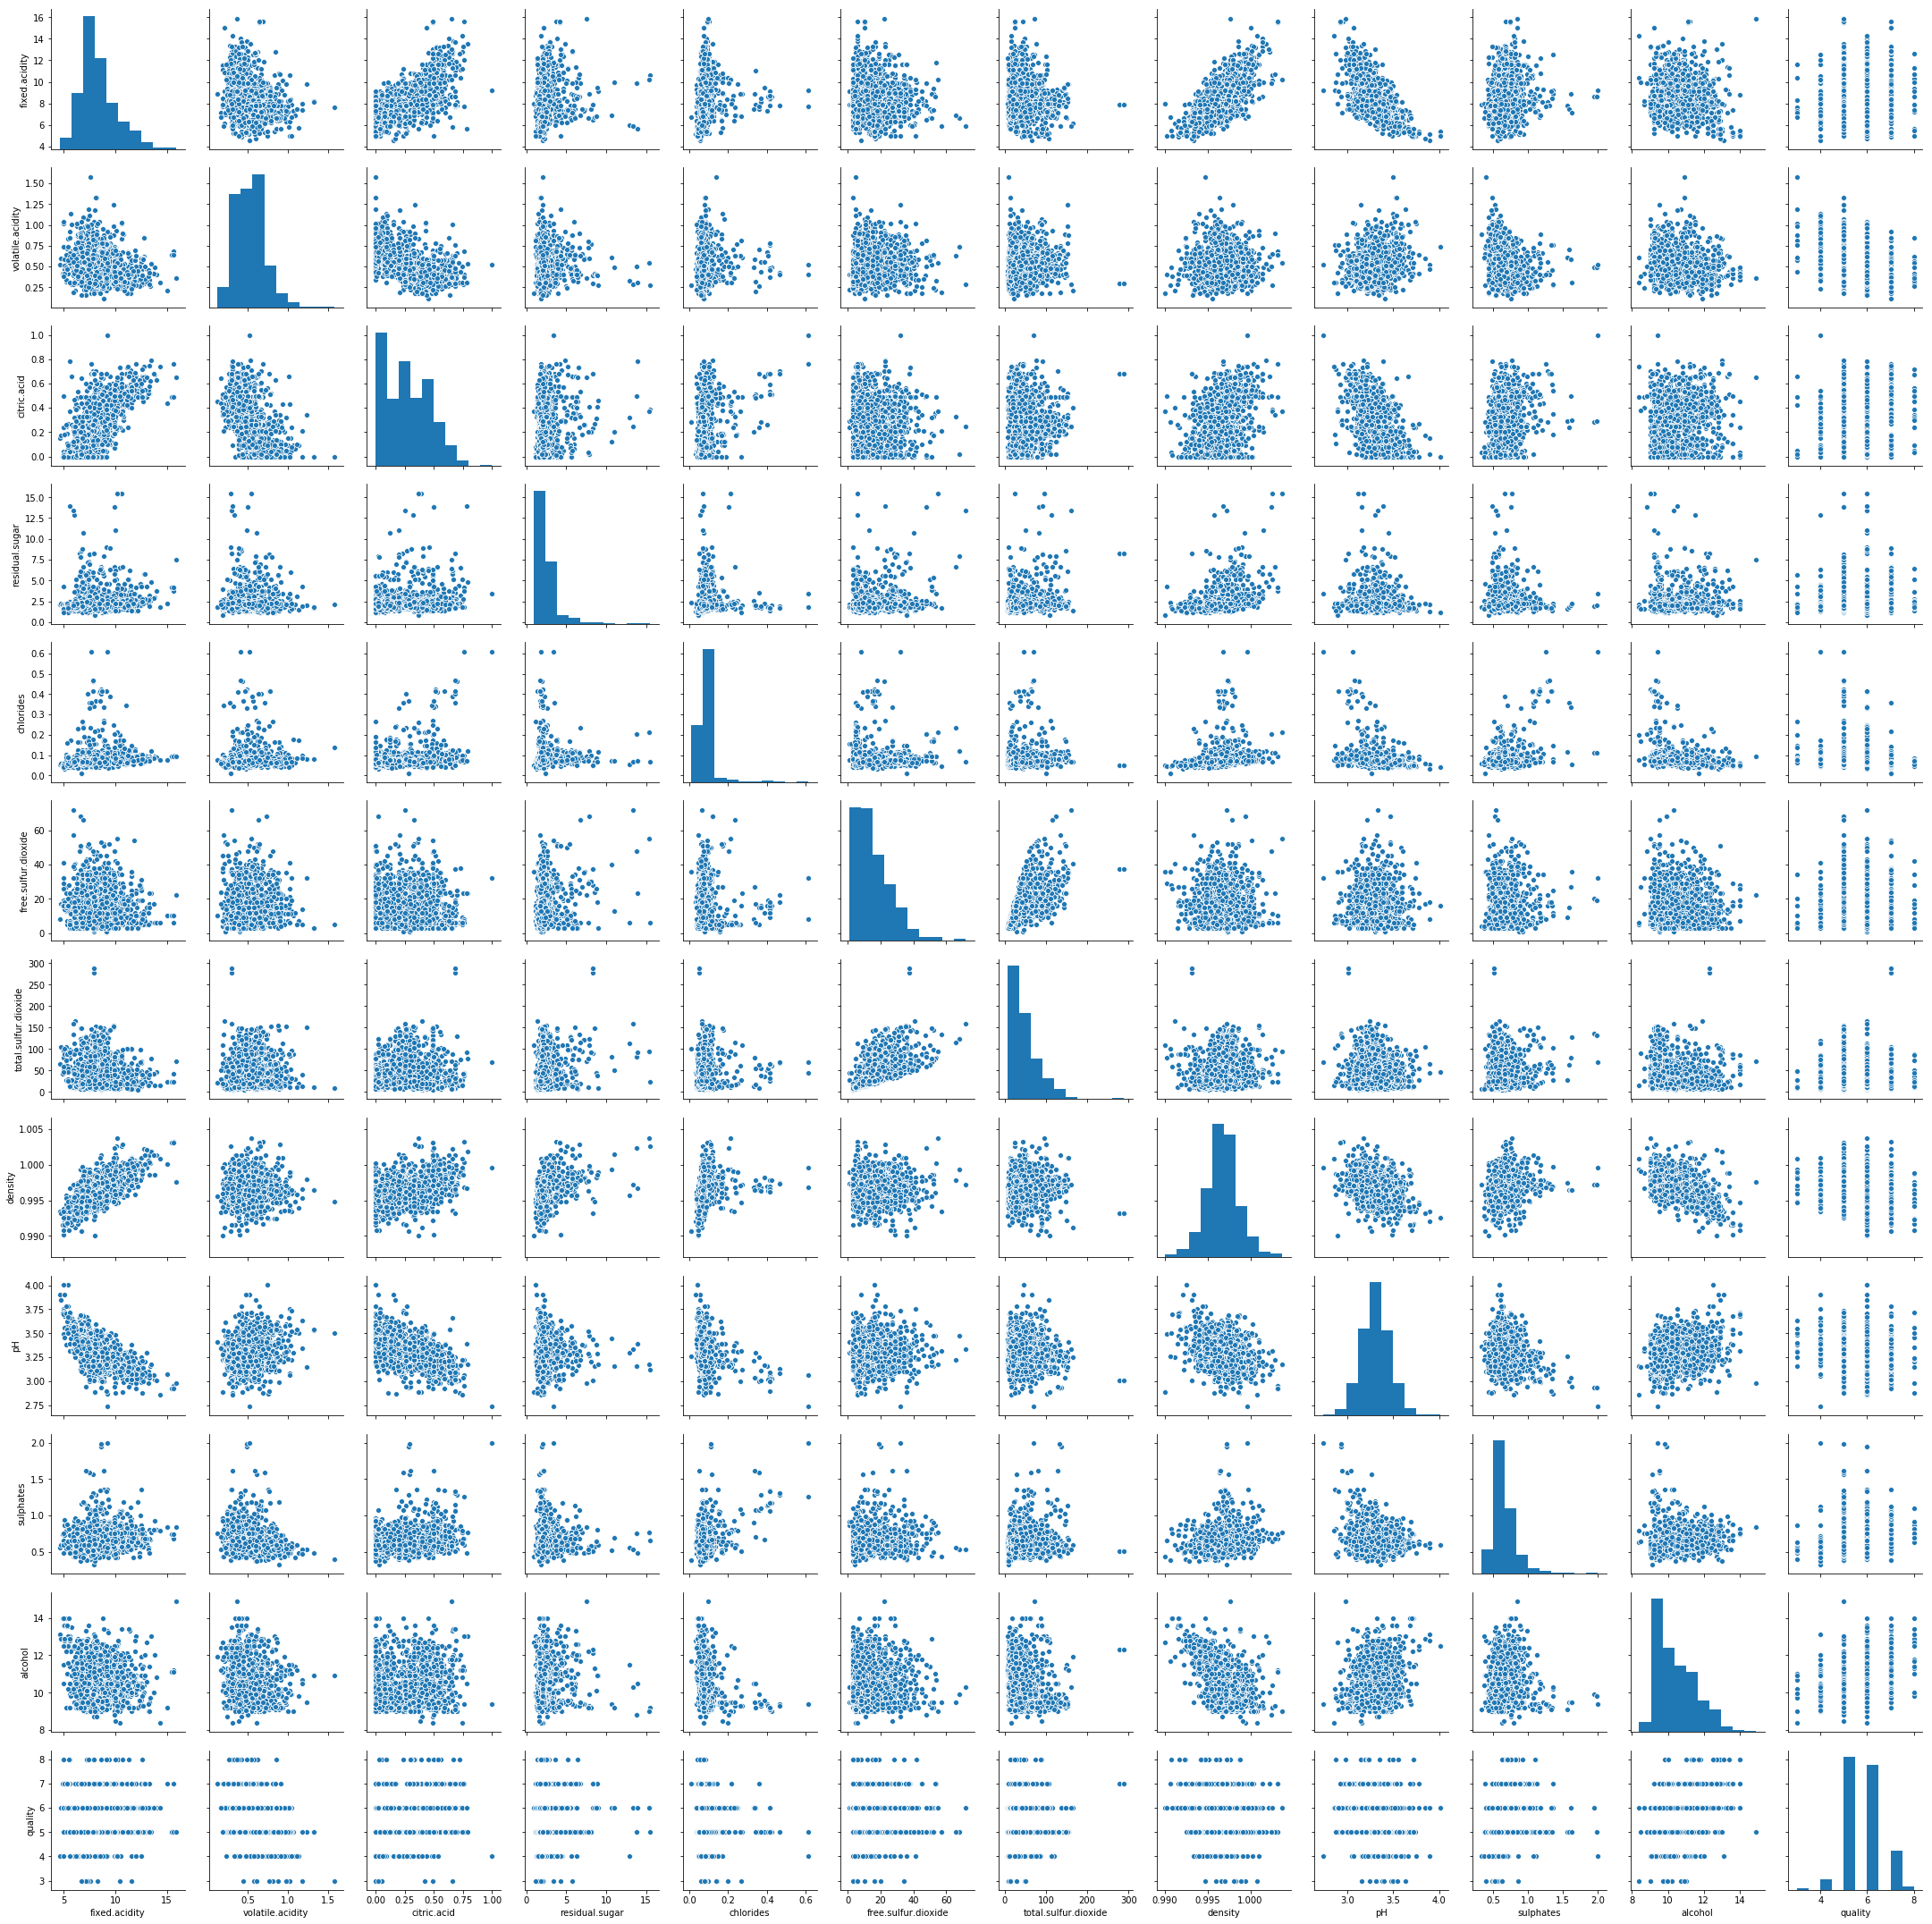

In [10]:
# Create a pairplot

sns.pairplot(data)

Pairplots are very pretty, but they're slow, and bombard us with a lot of information.  

We can use them to point us in the right direction though. The plots for quality confirm our choice not to focus on that variable, forming precise bands rather than anything with more intrinsic variability: just what you'd expect from a categorical variable. 

On the main diagonal, we can see a different kind of chart. This is because there's no point in plotting the correlation of a variable with itself - there's no new information to be found there. Instead, the plots which would otherwise be variables compared with themselves instead show a distribution of values for each column, so that you can check the shape of every distribution and/or immediately spot if you have low-variability columns (e.g. categorical variable with values present mainly for only 1 category.

All the other plots show much more varied and less clear relationships, making them more suited for regressional analysis. Some -such as fixed.acidity vs. density - seem to suggest a strong correlation between the two, while others (such as free.sulfur.dioxide vs. alcohol) seem less immediately connected.

In [11]:
# Display the same information numerically instead of visually

data.corr()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
fixed.acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile.acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric.acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual.sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free.sulfur.dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total.sulfur.dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


The information in the table above is more specific, but much harder to read. We can use a heatmap to get the benefits of both methods - visual and numeric.

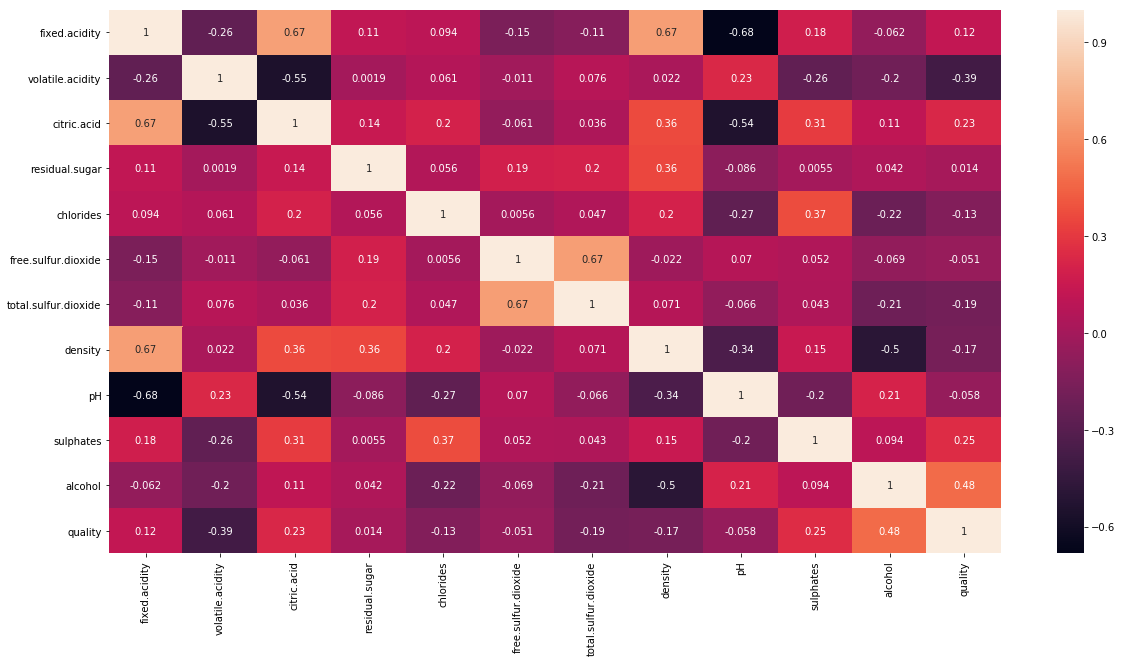

In [12]:
# Ensure the plot displays in a large enough size to be readable
plt.figure(figsize=(20,10))

# Create an annotated heatmap of the correlations

sns.heatmap(data.corr(), annot=True)

# The "annot" parameter tells the plot to display labels

Lighter colours show correlations closer to 1 (strong positive correlation), darker colours for correlations closer to -1 (strong negative correlation). We call the specific value for each correlation the "correlation coefficient".

We can use this plot to show us potentially interesting relationships. 

As we want to predict alcohol levels, let's look more closely at alcohol's relationship to density.

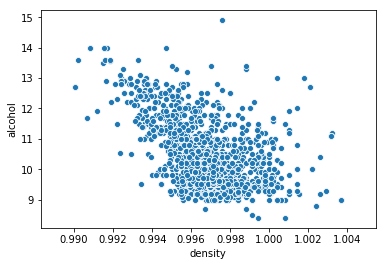

In [13]:
# Plot density against alcohol

sns.scatterplot(x="density", y="alcohol", data=data)

We can see a negative correlation, but not a particularly strong one, as the data points are quite spread out. Alcohol levels in wine are negatively correlated (a correlation coefficient of -0.5) with density. 

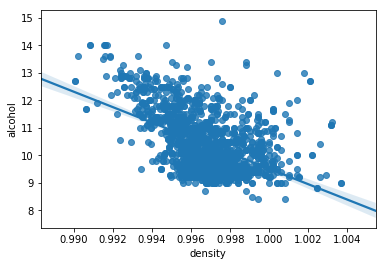

In [14]:
# Create a regplot to make the correlation more clear

sns.regplot(x="density", y="alcohol", data=data)

The line of best fit matches the overall shape of the data, but it's clear that the points are spread out all around it, rather than clustering close (as they would with a stronger correlation).

Let's see if we can predict alcohol based on density using linear regression. 

### Preparing the data

We're lucky today that this dataset is already very clean, and doesn't require much from us to be ready for analysis. 

However, one thing we do need to do is to split our dataset into test and training data. If we don't do this, then we can't effectively and reliably test our model.

For our first model, we're only going to focus on two variables - alcohol as our dependent, and density as our sole independent predictor.

In [15]:
# Create test and train datasets

# Create smaller datasets consisting of just our dependent and indepent variables

X = data[["density"]] 
y = data[["alcohol"]]

# Double brackets allow us to keep the column headings

# Split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

# The test_size parameter means we can train with 75% of the data, and test on 25%
# The random_state parameter allows our work to be checked and replicated by other data scientists

In [16]:
# Check that the sizes match and that all is fine

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1199, 1) (1199, 1)
(400, 1) (400, 1)


### Analysing the data

In [17]:
# Create the model

model = linear_model.LinearRegression(normalize=True)

# The normalise parameter allows us to deal with the different scales of our variables

In [39]:
# Train the model on our test data

model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [19]:
# Evaluate the model

print(model.score(X_train, y_train))

0.22940244226487727


The above score is called R-Squared, or the "coefficient of determination". Essentially, it is a measure of how well our model predicts the variations in the data away from the mean. 1 would would mean a perfect model that explains 100% of the variation; our model explains only about 23% of the variation from the mean.

In [20]:
# Use the model to make predictions about our test data

y_pred = model.predict(X_test)

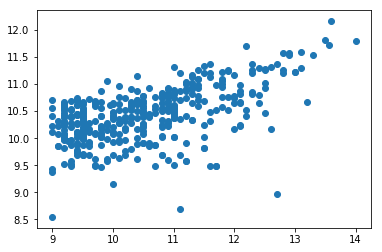

In [21]:
# Let's plot the predictions against the actual result

plt.scatter(y_test,y_pred)

The above scatterplot shows how well the predictions match the actual results. Along the x-axis, we have the actual alcohol level, and along the y-axis we have the predictions.

There is a visible positive correlation, as the model has not been totally unsuccesful, but it's clear that it is not incredibly accurate - wines with an actual alcohol level of 9 have been predicted as having alcohol levels from 8.5 to nearly 11. There are also lots of other outliers and inaccuracies.

Let's build a similar model using a different package, to see if we get a better result that way.

### Preparing the data

In [22]:
# Create test and train datasets. This is slightly different to our previous model
# sm does not include an intercept (the value of Y when X == 0) by default
# So we need to give the model the values in a format that is clear

X = data[["density"]] 
X = sm.add_constant(X)

In [23]:
# The rest of the preparation is as before.
y = data[["alcohol"]]

# Split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

### Analysing the data

In [24]:
# Create the model
model2 = sm.OLS(y_train, X_train)
# Fit the model
model2_results = model2.fit()

In [25]:
# Evaluate the model
model2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                alcohol   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     356.3
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           8.86e-70
Time:                        06:58:09   Log-Likelihood:                -1614.9
No. Observations:                1199   AIC:                             3234.
Df Residuals:                    1197   BIC:                             3244.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        278.2681     14.190     19.610      0.000     250.428     306.109
density     -268.7361     14.236    -18.877      0.000    -296.667    -240.805
==============================================================================
Omnibus:                      131.540   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.865
Skew:                           0.838   Prob(JB):                     3.23e-40
Kurtosis:                       3.910   Cond. No.                     1.06e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Statsmodels (sm) is a really great library to use because of how much detail you get from `summary`. There are lots of values you can explore the meaning of at leisure, but for our immediate purposes, only one jumps out. We can see that the R-Squared score is 0.229, which makes sense; it's the same value as the score from sklearn, and they've both used the same algorithm on the same data.

Useful link - https://www.theanalysisfactor.com/assessing-the-fit-of-regression-models/

In [26]:
# Use our new model to make predictions
y_pred = model2_results.predict(X_test)

Text(0, 0.5, 'Predicted')

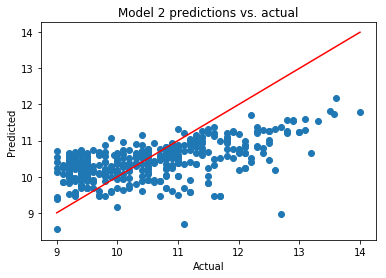

In [27]:
# Plot the predictions

# Build a scatterplot
plt.scatter(y_test, y_pred)

# Add a line for perfect correlation
plt.plot([x for x in range(9,15)],[x for x in range(9,15)], color='red')

# Label it nicely
plt.title("Model 2 predictions vs. actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")

The red line shows a theoretical perfect correlation between our actual and predicted values - the line we would have if every prediction was completely correct. It's clear that while our points have a broadly similar direction, they don't match the red line at all; we have more work to do. 

To get a better predictive model, we should use more than one variable.

### Preparing the data

In [28]:
# Create test and train datasets
# This is again very similar, but now we include more columns in the predictors

# Include all columns from data in X except alcohol & quality
X = data.drop(["alcohol","quality"],axis=1)

# Create constants for X, so the model knows its bounds
X = sm.add_constant(X)

y = data[["alcohol"]]

# Split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [29]:
# We can use almost identical code to create the third model, because it is the same algorithm, just different inputs

# Create the model
model3 = sm.OLS(y_train, X_train)
# Fit the model
model3_results = model3.fit()

In [30]:
# Evaluate the model

model3_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                alcohol   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     243.9
Date:                Thu, 21 Mar 2019   Prob (F-statistic):          1.29e-279
Time:                        06:58:10   Log-Likelihood:                -1102.0
No. Observations:                1199   AIC:                             2226.
Df Residuals:                    1188   BIC:                             2282.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  609.9302     15.228     40.052      0.000     580.053     639.808
fixed.acidity            0.5313      0.023     22.753      0.000       0.485       0.577
volatile.acidity         0.4048      0.130      3.115      0.002       0.150       0.660
citric.acid              0.8090      0.157      5.153      0.000       0.501       1.117
residual.sugar           0.2745      0.014     19.738      0.000       0.247       0.302
chlorides               -1.6562      0.436     -3.796      0.000      -2.512      -0.800
free.sulfur.dioxide     -0.0016      0.002     -0.680      0.497      -0.006       0.003
total.sulfur.dioxide    -0.0022      0.001     -2.750      0.006      -0.004      -0.001
density               -619.7392     15.608    -39.708      0.000    -650.361    -589.118
pH                       3.6289      0.175     20.686      0.000       3.285       3.973
sulphates                1.3814      0.121     11.447      0.000       1.145       1.618
==============================================================================
Omnibus:                       69.565   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.933
Skew:                           0.396   Prob(JB):                     5.01e-30
Kurtosis:                       4.440   Cond. No.                     7.58e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R-Squared score shows a big improvement - our first model predicted only around 20% of the variation, but now we are predicting 67%!

Note the free.sulfur.dioxide value - the coefficient is extremely close to zero, and the P value is high; essentially, it is unimportant and mostly noise, not a useful predictor.

In [31]:
# Use our new model to make predictions
y_pred = model3_results.predict(X_test)

Text(0, 0.5, 'Predicted')

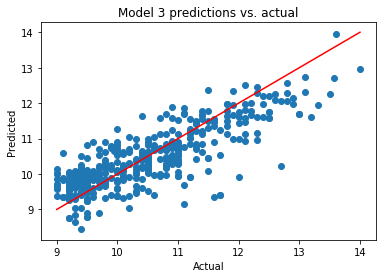

In [32]:
# Plot the predictions

# Build a scatterplot
plt.scatter(y_test, y_pred)

# Add a line for perfect correlation
plt.plot([x for x in range(9,15)],[x for x in range(9,15)], color='red')

# Label it nicely
plt.title("Model 3 predictions vs. actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")

We've now got a much closer match between our data and our predictions, and we can see that the shape of the data points is much more similar to the red line. 

Let's remove free.sulfur.dioxide, as it is not a useful predictor. This should hopefully reduce the noise and let us make more accurate predictions.

In [33]:
# Create test and train datasets
# This is again very similar, but now we include more columns in the predictors

# Include all columns from data in X except alcohol, quality & free.sulfur.dioxide
X = data.drop(["alcohol","quality","free.sulfur.dioxide"],axis=1)

# Create constants for X, so the model knows its bounds
X = sm.add_constant(X)

y = data[["alcohol"]]

# Split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [34]:
# Create the fourth model
model4 = sm.OLS(y_train, X_train)
# Fit the model
model4_results = model4.fit()
# Evaluate the model
model4_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                alcohol   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     271.1
Date:                Thu, 21 Mar 2019   Prob (F-statistic):          9.61e-281
Time:                        06:58:10   Log-Likelihood:                -1102.2
No. Observations:                1199   AIC:                             2224.
Df Residuals:                    1189   BIC:                             2275.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  608.9046     15.150     40.192      0.000     579.181     638.628
fixed.acidity            0.5299      0.023     22.785      0.000       0.484       0.576
volatile.acidity         0.4214      0.128      3.303      0.001       0.171       0.672
citric.acid              0.8266      0.155      5.339      0.000       0.523       1.130
residual.sugar           0.2731      0.014     19.874      0.000       0.246       0.300
chlorides               -1.6760      0.435     -3.851      0.000      -2.530      -0.822
total.sulfur.dioxide    -0.0025      0.001     -4.337      0.000      -0.004      -0.001
density               -618.6593     15.523    -39.855      0.000    -649.115    -588.204
pH                       3.6126      0.174     20.794      0.000       3.272       3.953
sulphates                1.3784      0.121     11.432      0.000       1.142       1.615
==============================================================================
Omnibus:                       69.644   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.137
Skew:                           0.394   Prob(JB):                     2.74e-30
Kurtosis:                       4.451   Cond. No.                     7.21e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

There's no overall change in the model's R-Squared score, so we know that the variable was not an important or relevant predictor.

We can check another metric as well - the RMSE (Root Mean Squared Error). This is a measure of the accuracy of a regression model. Very simply put, it's formed by finding the average difference between predictions and actual values. You can read more about it [here](https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d).

In [35]:
# Define a function to check the RMSE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [36]:
# get predictions from model4
y_pred = model4_results.predict(X_test)

# put predictions & actual into a dataframe
matches = pd.DataFrame(y_test)
matches.rename(columns = {'alcohol':'actual'}, inplace=True)
matches["predicted"] = y_pred

rmse(matches["actual"], matches["predicted"])

0.63141138992751

The RMSE tells us how far, on average, our predictions were wrong. An RMSE of 0 would mean we were making perfect predictions. 0.6 means that we are, on average, about 0.6 of a unit of alcohol away from the correct answer. That's not bad at all.

We can also see from our early heat map that fixed.acidity, volatile.acidity, and citric.acid are all correlated with pH. We can make a model that ignores those three variables and just uses pH, in an attempt to remove redundancy from our model.

In [37]:
# Create test and train datasets
# This is again very similar, but now we include more columns in the predictors

# Include the remaining six columns as predictors
X = data[["residual.sugar","chlorides","total.sulfur.dioxide","density","pH","sulphates"]]

# Create constants for X, so the model knows its bounds
X = sm.add_constant(X)

y = data[["alcohol"]]

# Split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [38]:
# Create the fifth model
model5 = sm.OLS(y_train, X_train)
# Fit the model
model5_results = model5.fit()
# Evaluate the model
model5_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                alcohol   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     144.2
Date:                Thu, 21 Mar 2019   Prob (F-statistic):          1.72e-137
Time:                        06:58:10   Log-Likelihood:                -1443.9
No. Observations:                1199   AIC:                             2902.
Df Residuals:                    1192   BIC:                             2937.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  332.9081     14.505     22.951      0.000     304.450     361.366
residual.sugar           0.2186      0.018     12.271      0.000       0.184       0.254
chlorides               -4.7322      0.524     -9.034      0.000      -5.760      -3.704
total.sulfur.dioxide    -0.0075      0.001    -10.321      0.000      -0.009      -0.006
density               -324.8950     14.401    -22.561      0.000    -353.148    -296.642
pH                       0.0995      0.167      0.596      0.551      -0.228       0.427
sulphates                1.8524      0.150     12.362      0.000       1.558       2.146
==============================================================================
Omnibus:                      126.337   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              201.687
Skew:                           0.736   Prob(JB):                     1.60e-44
Kurtosis:                       4.367   Cond. No.                     5.08e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.08e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R-squared score has reduced, showing us that actually, the removed columns were important. In fact, if you look at the P value for pH, you can see that this model thinks it is not a significant factor.

### Conclusions & next steps

Our most effective & simplest model was model4 - it used the fewest predictors to get the best result.

All of our models in this notebook have used the OLS algorithm - Ordinary Least Squares. There are many other regression algorithms, and I encourage you to investigate them. You can find some examples [here](https://www.statsmodels.org/dev/examples/index.html#regression).

You might also wish to investigate the detailed statistics we have seen in `summary`. The more you learn about how these models work, the better you'll understand regression, and the better the models you'll be able to build.